In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from tqdm import tqdm
import matplotlib.pyplot as plt
from FinalModel import AdvancedSegmentationCNN

class FeatureExtractor:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.features = None
        self.hook = None
        self._register_hook()

    def _register_hook(self):
        for name, module in self.model.named_modules():
            if name == self.layer_name:
                self.hook = module.register_forward_hook(self._hook_fn)
                break

    def _hook_fn(self, module, input, output):
        self.features = output

    def remove_hook(self):
        if self.hook:
            self.hook.remove()

    def get_features(self):
        return self.features

class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()

    def forward(self, teacher_features, student_features):
        # Align spatial dimensions
        if teacher_features.shape[2:] != student_features.shape[2:]:
            teacher_features = torch.nn.functional.interpolate(
                teacher_features, size=student_features.shape[2:], mode="bilinear", align_corners=False
            )
        
        # Align channel dimensions
        if teacher_features.shape[1] != student_features.shape[1]:
            channel_projector = nn.Conv2d(
                in_channels=teacher_features.shape[1],
                out_channels=student_features.shape[1],
                kernel_size=1
            ).to(teacher_features.device)
            teacher_features = channel_projector(teacher_features)
        
        # Flatten features
        teacher_flat = teacher_features.view(teacher_features.size(0), -1)
        student_flat = student_features.view(student_features.size(0), -1)
        
        # Compute cosine similarity
        return 1 - torch.nn.functional.cosine_similarity(teacher_flat, student_flat, dim=1).mean()



# Preprocessing
def preprocess(image, target):
    # Define transformations for the input image
    transforms = Compose([
        Resize((256, 256)),
        ToTensor(),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    # Apply transforms to the image
    image = transforms(image)

    # Resize and convert the target (segmentation mask)
    target = target.resize((256, 256))  # Resize the target
    target = torch.as_tensor(np.array(target), dtype=torch.long)  # Convert to tensor

    return image, target


# Visualization function
def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            target_np = targets[0].cpu().numpy()
            prediction_np = predictions[0]

            # Visualize input, ground truth, and prediction
            input_img = images[0].permute(1, 2, 0).cpu().numpy()
            input_img = (input_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            input_img = np.clip(input_img, 0, 1)

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(input_img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(target_np, cmap="tab20")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(prediction_np, cmap="tab20")
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
            break  # Visualize only one random image per epoch

def train_knowledge_distillation_feature_based(
    teacher, student, train_loader, val_loader, epochs, learning_rate, feature_loss_weight, ce_loss_weight, device, save_path
):
    ce_loss = nn.CrossEntropyLoss(ignore_index=255)
    cosine_loss = CosineSimilarityLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    # Attach a feature extractor to the teacher model
    teacher_extractor = FeatureExtractor(teacher, layer_name="backbone.layer4")  # Example layer

    teacher.eval()
    student.train()

    best_val_loss = float('inf')

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Teacher forward pass (no gradients)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)['out']
                teacher_features = teacher_extractor.get_features()

            # Student forward pass
            student_outputs = student(inputs)
            student_features = student.features

            # Feature-based loss (Cosine similarity)
            feature_loss = cosine_loss(teacher_features, student_features)

            # Cross-entropy loss
            label_loss = ce_loss(student_outputs, labels)

            # Weighted loss
            loss = feature_loss_weight * feature_loss + ce_loss_weight * label_loss

            # Backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss / len(train_loader)}")

        # Validation phase
        val_loss = 0.0
        student.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                student_outputs = student(inputs)
                label_loss = ce_loss(student_outputs, labels)
                val_loss += label_loss.item()

                # Visualize one prediction on the first batch
                if i == 0:
                    visualize_prediction(student, [(inputs, labels)], device)

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss}")

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(student.state_dict(), save_path)
            print(f"Validation loss improved to {avg_val_loss:.4f}. Model weights saved!")

    # Remove the hook after training
    teacher_extractor.remove_hook()

In [2]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = VOCSegmentation(
        root="./data",
        year="2012",
        image_set="train",
        download=True,
        transforms=preprocess
    )
    val_dataset = VOCSegmentation(
        root="./data",
        year="2012",
        image_set="val",
        download=True,
        transforms=preprocess
    )
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


Using cache found in C:\Users\David Hoernke/.cache\torch\hub\pytorch_vision_v0.10.0
C:\PythonEnviorments\ML-Env_wCudas\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\PythonEnviorments\ML-Env_wCudas\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
    teacher = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True).to(device)
    student = AdvancedSegmentationCNN(num_classes=21).to(device)
    student.load_state_dict(torch.load("HeavyAugment_segmentation_model_best_augmented1.pth"))


Using cache found in C:\Users\David Hoernke/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\David Hoernke\AppData\Local\Temp\ipykernel_25716\3986736544.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related 

<All keys matched successfully>

Epoch 1/50: 100%|██████████| 366/366 [01:30<00:00,  4.03it/s]


Epoch 1/50, Train Loss: 0.7681811732021185


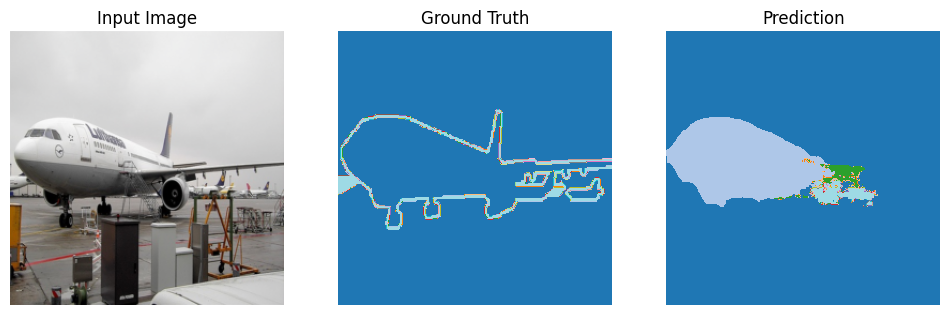

Epoch 1/50, Validation Loss: 0.7105207648897959
Validation loss improved to 0.7105. Model weights saved!


Epoch 2/50: 100%|██████████| 366/366 [01:28<00:00,  4.14it/s]


Epoch 2/50, Train Loss: 0.754310317703935


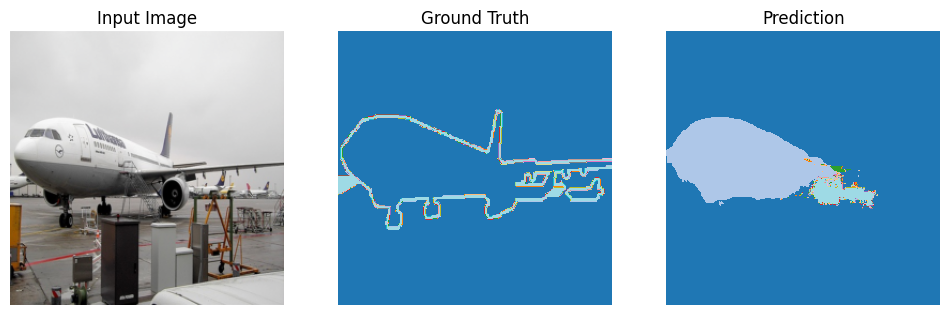

Epoch 2/50, Validation Loss: 0.7107468888204617


Epoch 3/50: 100%|██████████| 366/366 [01:25<00:00,  4.26it/s]


Epoch 3/50, Train Loss: 0.7355798911201498


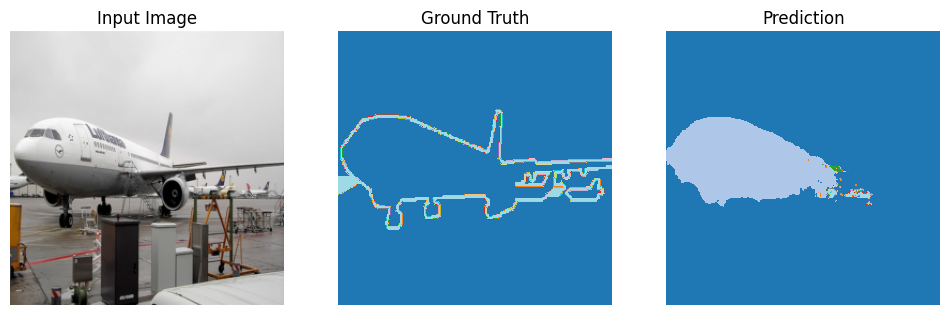

Epoch 3/50, Validation Loss: 0.6949976400649251
Validation loss improved to 0.6950. Model weights saved!


Epoch 4/50: 100%|██████████| 366/366 [01:26<00:00,  4.24it/s]


Epoch 4/50, Train Loss: 0.7250602740407641


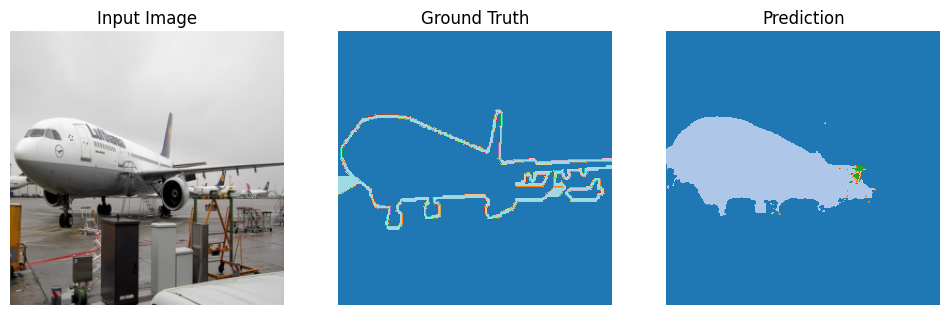

Epoch 4/50, Validation Loss: 0.7015489844743871


Epoch 5/50: 100%|██████████| 366/366 [01:26<00:00,  4.22it/s]


Epoch 5/50, Train Loss: 0.714972703508992


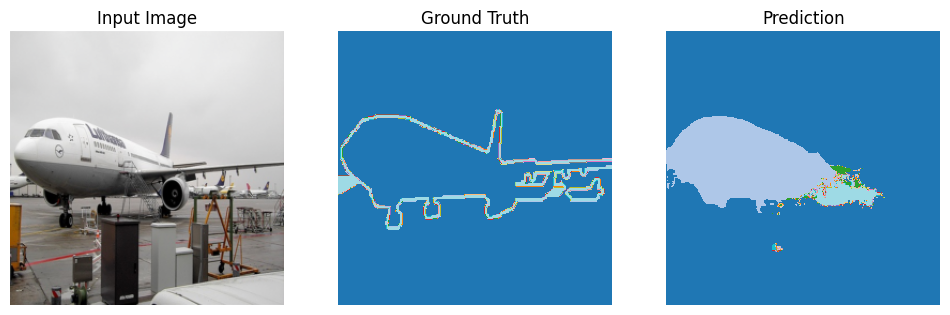

Epoch 5/50, Validation Loss: 0.7061077891630904


Epoch 6/50: 100%|██████████| 366/366 [01:26<00:00,  4.24it/s]


Epoch 6/50, Train Loss: 0.6992485353041217


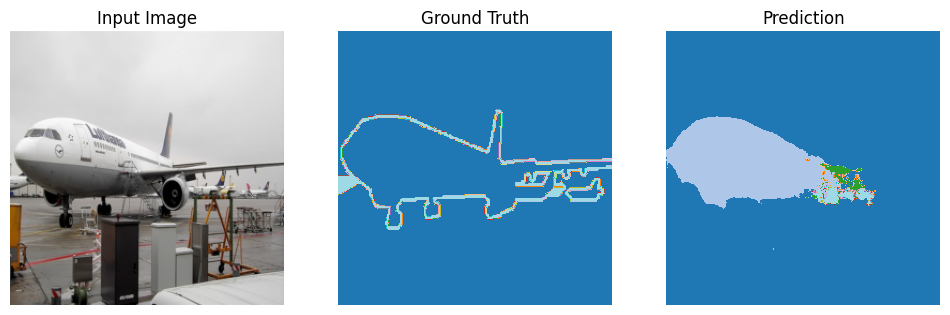

Epoch 6/50, Validation Loss: 0.7206300583670618


Epoch 7/50: 100%|██████████| 366/366 [01:26<00:00,  4.22it/s]


Epoch 7/50, Train Loss: 0.6925618182765981


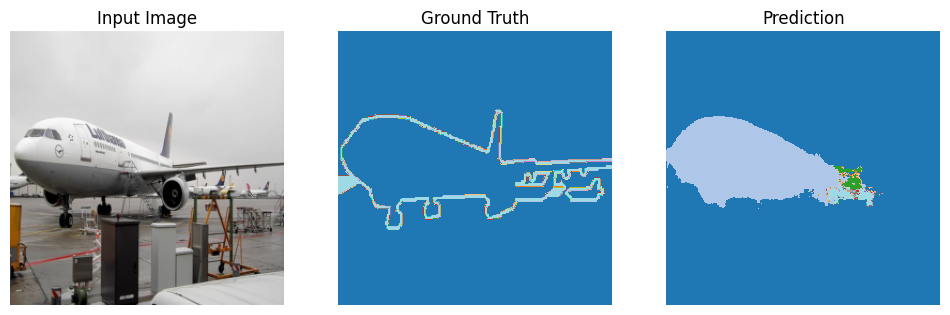

Epoch 7/50, Validation Loss: 0.7303073908261359


Epoch 8/50: 100%|██████████| 366/366 [01:26<00:00,  4.23it/s]


Epoch 8/50, Train Loss: 0.6845938164354022


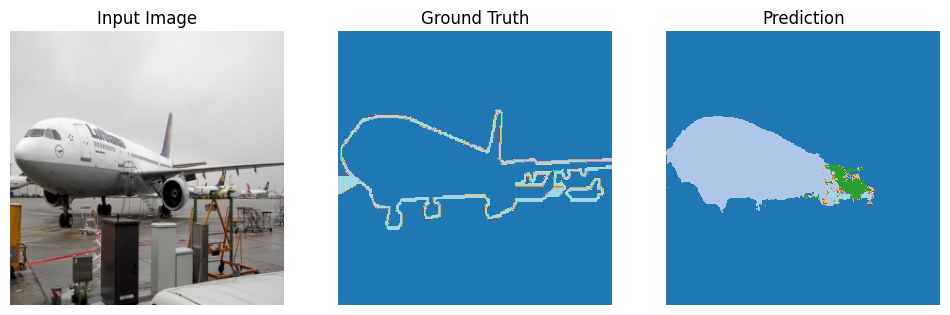

Epoch 8/50, Validation Loss: 0.7276559270938894


Epoch 9/50: 100%|██████████| 366/366 [01:23<00:00,  4.39it/s]


Epoch 9/50, Train Loss: 0.6741281764917686


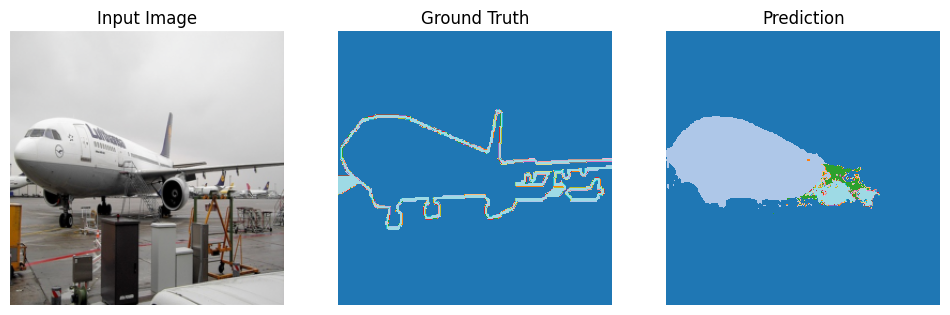

Epoch 9/50, Validation Loss: 0.7421111469836931


Epoch 10/50: 100%|██████████| 366/366 [01:23<00:00,  4.38it/s]


Epoch 10/50, Train Loss: 0.6656007509413964


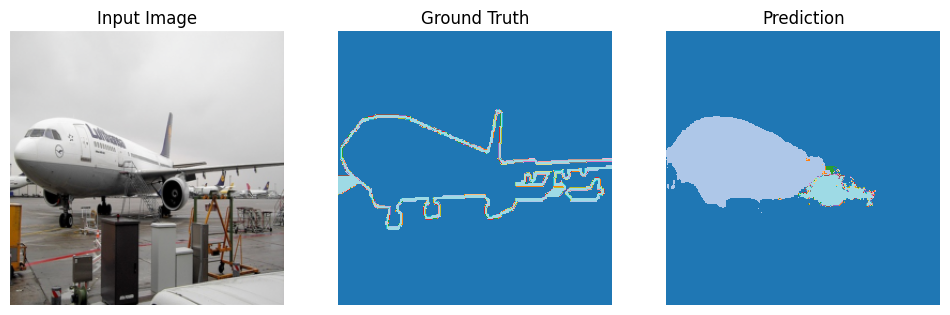

Epoch 10/50, Validation Loss: 0.7709738964384253


Epoch 11/50: 100%|██████████| 366/366 [01:23<00:00,  4.37it/s]


Epoch 11/50, Train Loss: 0.6600425429031497


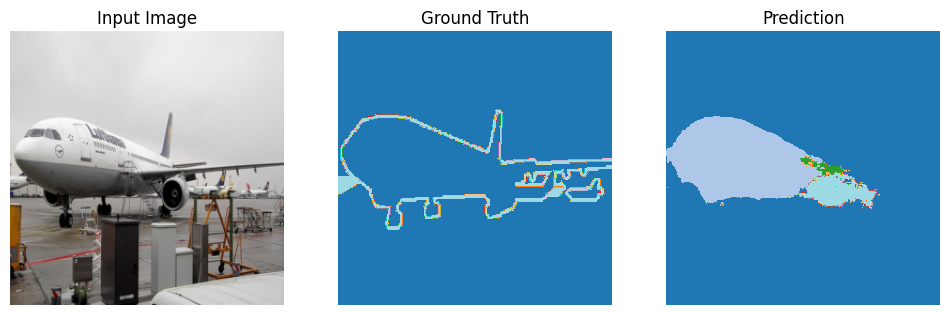

Epoch 11/50, Validation Loss: 0.7870941426471574


Epoch 12/50: 100%|██████████| 366/366 [01:24<00:00,  4.35it/s]


Epoch 12/50, Train Loss: 0.6501213554801837


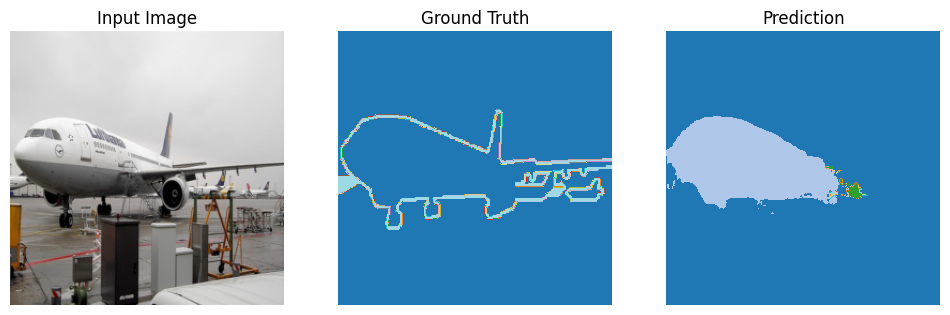

Epoch 12/50, Validation Loss: 0.7911359799548614


Epoch 13/50: 100%|██████████| 366/366 [01:23<00:00,  4.38it/s]


Epoch 13/50, Train Loss: 0.6400628563810568


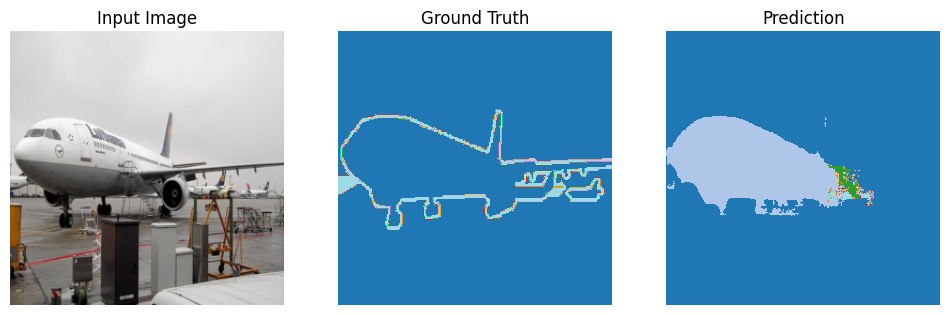

Epoch 13/50, Validation Loss: 0.7682817555738218


Epoch 14/50: 100%|██████████| 366/366 [01:23<00:00,  4.38it/s]


Epoch 14/50, Train Loss: 0.6355295916561221


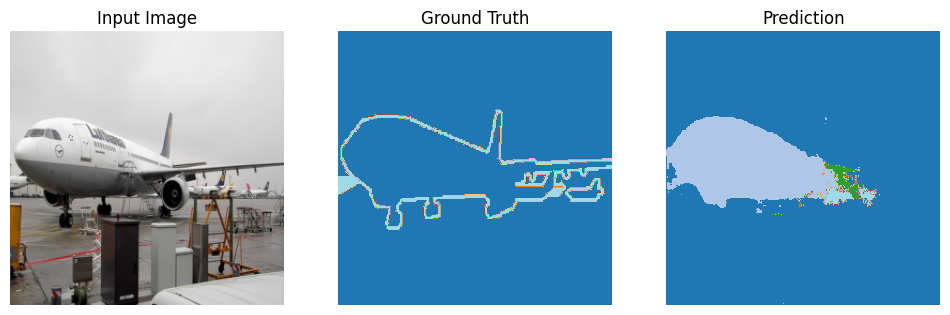

Epoch 14/50, Validation Loss: 0.7874026468470077


Epoch 15/50: 100%|██████████| 366/366 [01:22<00:00,  4.41it/s]


Epoch 15/50, Train Loss: 0.6256402095810312


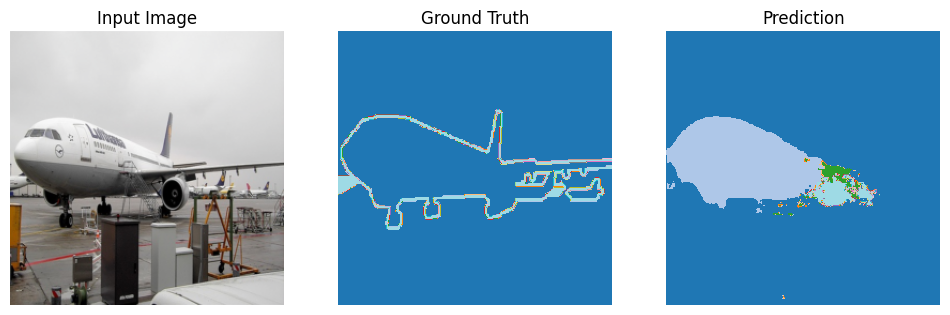

Epoch 15/50, Validation Loss: 0.8345813302954367


Epoch 16/50: 100%|██████████| 366/366 [01:22<00:00,  4.43it/s]


Epoch 16/50, Train Loss: 0.6217647225804668


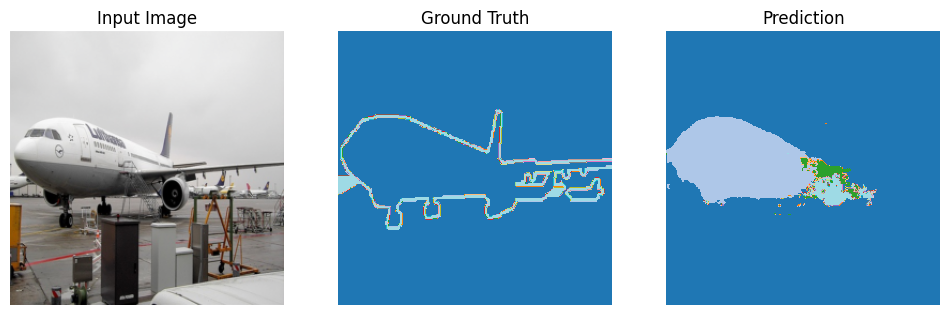

Epoch 16/50, Validation Loss: 0.8272716049156241


Epoch 17/50: 100%|██████████| 366/366 [01:24<00:00,  4.33it/s]


Epoch 17/50, Train Loss: 0.6136083937570697


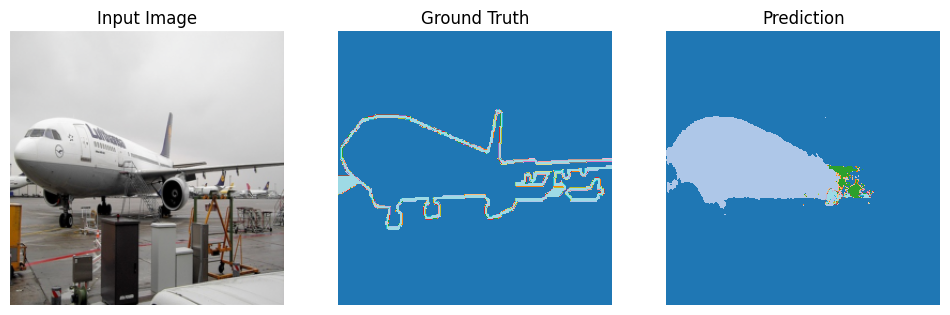

Epoch 17/50, Validation Loss: 0.7982154477480029


Epoch 18/50:  72%|███████▏  | 262/366 [01:01<00:24,  4.20it/s]

In [ ]:
    train_knowledge_distillation_feature_based(
        teacher=teacher,
        student=student,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=50,
        learning_rate=1e-4,
        feature_loss_weight=0.4,
        ce_loss_weight=0.6,
        device=device,
        save_path="Cosine_student_model_TeacherBIAS0.6.pth"
    )